In [33]:
import os
import torch
import cv2 as cv
import math
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms.functional as f
from pytorch_ssim import SSIM

In [6]:
HEIGHT = 180
WIDTH = 240
BATCH_SIZE = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
def rotate_to_landscape(img):
    if img.shape[1] < img.shape[0]:
        img = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
    return img

In [8]:
def downscale_images(img):
    img = cv.resize(img, (WIDTH, HEIGHT), interpolation=cv.INTER_AREA)
    return img

In [9]:
def get_data (index, batch_size, dataset_path):
    file_name = os.listdir(dataset_path)[index]
    file_path = os.path.join(dataset_path, file_name)
    img = cv.imread(file_path)
    img = rotate_to_landscape(img)
    img = downscale_images(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2HLS)
    img = img / np.array([179,255,255])
    
    img_batch = torch.tensor(img, dtype=torch.float,requires_grad=True).reshape((1, 3, WIDTH, HEIGHT))
    
    for file_name in os.listdir(dataset_path)[index + 1 : index + batch_size]:
        file_path = os.path.join(dataset_path, file_name)
        img = cv.imread(file_path)
        img = rotate_to_landscape(img)
        img = downscale_images(img)
        img = cv.cvtColor(img, cv.COLOR_BGR2HLS)
        img = img / np.array([179,255,255])
        img = torch.tensor(img, dtype=torch.float, requires_grad=True).reshape((1, 3, WIDTH, HEIGHT))
        img_batch = torch.cat((img_batch,img), 0)
    
    return img_batch

In [10]:
def hls_tensor_to_img (hls_img, index):
    hls_img = hls_img[index,:,:,:]
    hls_img = hls_img.reshape(HEIGHT, WIDTH, 3).detach().cpu().numpy()
    hls_img = (hls_img * np.array([179,255,255])).astype(np.uint8)
    bgr_img = cv.cvtColor(hls_img, cv.COLOR_HLS2BGR)
    return bgr_img

In [11]:
hls_img = get_data(42,4, r"C:\Users\ratho\OneDrive\Desktop\dataset1\Train\X")
bgr_img = hls_tensor_to_img(hls_img, 0)

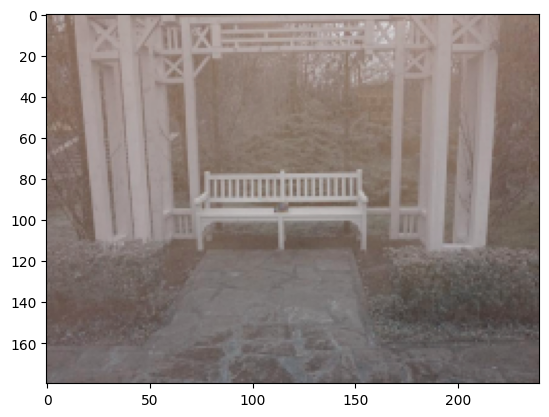

In [12]:
plt.imshow(bgr_img)

In [13]:
class Spatial_Attention_Block(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out2 = self.relu(self.conv2(out1))
        out3 = self.relu(self.conv3(out2))
        
        return self.sigmoid(x + out1 + out2 + out3)

In [14]:
class Channel_Attention_Block(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        
        out = avg_out + max_out
        return self.sigmoid(out)

In [15]:
class Dehaze_Model(nn.Module):
    def __init__(self, nf, in_channels=3):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, nf, 3, 1, 1),
                                 nn.ReLU())
        self.sa = Spatial_Attention_Block(nf)
        self.ca = Channel_Attention_Block(nf)
        
        self.conv2 = nn.Conv2d(nf, 6, 3, 1, 1)
        
        self.conv3 = nn.Sequential(nn.Conv2d(6,nf,3,1,1),
                                  nn.ReLU(),
                                  nn.Conv2d(nf,3,1,1))

        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x1 = self.conv1(x)
        ca_x = self.ca(x1)
        x1 = x1 * ca_x
        sa_x = self.sa(x1)
        x1 = x1 * sa_x
        x1 = self.conv2(x1)
        alpha, beta = x1[:,:3,:,:], x1[:,3:,:,:]
        x2 = alpha * x + beta
        noise = torch.rand_like(x)
        x2 = torch.cat((x2,noise),1)
        x3= self.conv3(x2)
        return self.sigmoid(x3)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, num_channels=3, num_filters=16, num_classes=1):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_filters * 4, num_filters * 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.adaptive_pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters * 8, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.adaptive_pooling(x)
        
        x = self.fc_layers(x)
        return x

In [17]:
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:26])
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, input_image1, input_image2):
        feature_representation1 = self.feature_extractor(input_image1)
        feature_representation2 = self.feature_extractor(input_image2)
        return nn.MSELoss()(feature_representation1, feature_representation2)

In [18]:
class VGG_L1_loss(nn.Module):
    def __init__(self, beta=0.1) -> None:
        super().__init__()
        self.vgg_loss = VGGLoss()
        self.l1_loss = nn.L1Loss()
        self.beta = beta

    def forward(self, input_image1, input_image2):
        l2 = self.vgg_loss(input_image1, input_image2)
        l1 = self.l1_loss(input_image1, input_image2)
        return l1 + self.beta * l2

In [19]:
g = Dehaze_Model(16).to(device)
d = Discriminator().to(device)

In [20]:
loss_fn_g = nn.L1Loss().to(device)
loss_fn_d = nn.BCELoss().to(device)

In [21]:
optimizer_g = optim.Adam(g.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer_d = optim.Adam(d.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [22]:
# EPOCHS = 40
# x_dataset_path = '/kaggle/input/nh-dehazing/dataset1/Train/X'
# y_dataset_path = '/kaggle/input/nh-dehazing/dataset1/Train/Y'
# num_of_training_images = len(os.listdir(x_dataset_path))
# for epoch in range(EPOCHS):
#     for i in range(0, num_of_training_images, BATCH_SIZE):
#         X = get_data(i, BATCH_SIZE, x_dataset_path)
#         Y = get_data(i, BATCH_SIZE, y_dataset_path)
#         X, Y = X.to(device), Y.to(device)

#         Y_ = g(X)
#         optimizer_g.zero_grad()
#         loss = loss_fn_g(Y_,Y)
#         loss.backward()
#         optimizer_g.step()
        
#     print(
#         f"Epoch [{epoch+1}/{EPOCHS}] Loss: {loss.item()}"
#     )

In [34]:
ssim_loss = SSIM(window_size=11)

In [36]:
EPOCHS = 1
x_dataset_path = r"C:\Users\ratho\OneDrive\Desktop\dataset1\Train\X"
y_dataset_path = r"C:\Users\ratho\OneDrive\Desktop\dataset1\Train\Y"
num_of_training_images = len(os.listdir(x_dataset_path))
for epoch in range(EPOCHS):
    for i in range(0, num_of_training_images, BATCH_SIZE):
        X = get_data(i, BATCH_SIZE, x_dataset_path)
        Y = get_data(i, BATCH_SIZE, y_dataset_path)
        X, Y = X.to(device), Y.to(device)

        Y_ = g(X)
        d_predict1 = d(Y_)
        d_predict2 = d(Y)
        
        optimizer_g.zero_grad()
        l1 = loss_fn_g(Y_,Y)
        l2 = loss_fn_d(d_predict1,torch.ones_like(d_predict1).to(device)) 
        loss_g = l1 + 0.1*l2 
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        
        Y_ = g(X)
        d_predict1 = d(Y_)
        d_predict2 = d(Y)

        optimizer_d.zero_grad()
        l1 = loss_fn_d(d_predict1,torch.zeros_like(d_predict1).to(device)) 
        l2 = loss_fn_d(d_predict2,torch.ones_like(d_predict2).to(device))
        loss_d = 0.5 * (l1 + l2)
        loss_d.backward()
        optimizer_d.step()
        
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] Loss: {loss_g.item()}"
    )

Epoch [1/1] Loss: 0.8614983558654785


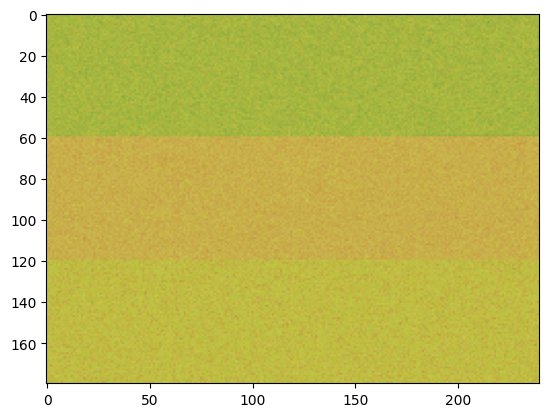

In [ ]:
X = get_data(1,1,r"C:\Users\ratho\OneDrive\Desktop\dataset1\Train\X").to(device)
Y_ = g(X)
bgr_Y_ = hls_tensor_to_img(Y_, 0)
plt.imshow(bgr_Y_)

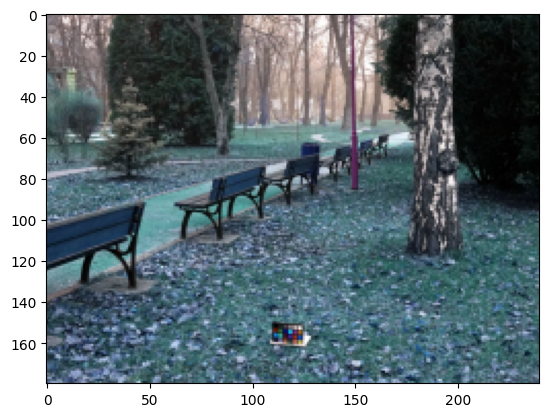

In [ ]:
X = get_data(1,1,r"C:\Users\ratho\OneDrive\Desktop\dataset1\Train\X").to(device)
bgr_Y_ = hls_tensor_to_img(X, 0)
plt.imshow(bgr_Y_)

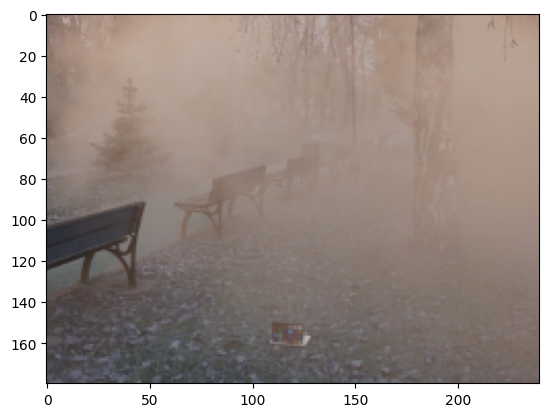

In [ ]:
hls_img = get_data(1,1, '/kaggle/input/nh-dehazing/dataset1/Validation/X')
bgr_img = hls_tensor_to_img(hls_img, 0)
plt.imshow(bgr_img)